In [1]:
# This is a literate code document for experimenting which helps with
# exploring the machine learning aspects before putting essential portions into scripts and final report
# Created on: 2021-11-24
# Updated on: 2021-11-25

# Import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from docopt import docopt
from sklearn import datasets
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)

# Reads already-split train and test dfs (80-20%), and creates train and split parts 

train_df = pd.read_csv("../data/processed/train_df.csv")
test_df = pd.read_csv("../data/processed/test_df.csv")

X_train = train_df.drop(columns=["total_cup_points"])
X_test = test_df.drop(columns=["total_cup_points"])

y_train = train_df["total_cup_points"]
y_test = test_df["total_cup_points"]

# Create a preprocessor for feature transformations

numeric_features = [
    "moisture",
    "quakers",
    "altitude_mean_meters"
]

categorical_features = [
    "country_of_origin",
    "harvest_year",
    "variety",
    "processing_method",
    "category_one_defects",
    "color",
    "category_two_defects",
    "region"
    ]

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_features)
)


In [2]:
# A function to get cross-validated scores on the models

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)


### Regression

In [3]:
# Building regression models

models = {
    "Ridge": Ridge(random_state=123),
    "RForest_Regressor": RandomForestRegressor(random_state=123)
}

results_dict = {}

for k, v in models.items():
    pipe_multi = make_pipeline(preprocessor, v)
    results_dict[k] = mean_std_cross_val_scores(pipe_multi, X_train, y_train, 
                                             cv=5, return_train_score=True)
    

# --> FIRST OUTPUT: Table of results of 2 models from CV

results_dict = pd.DataFrame(results_dict)
results_dict
# ==> RESULT: We select RF Regressor with better CV performance: 0.177 for R squared 
# ==> NEXT: We try hyperparameter optimization on RF

,Ridge,RForest_Regressor
fit_time,0.010 (+/- 0.003),0.359 (+/- 0.010)
score_time,0.005 (+/- 0.001),0.012 (+/- 0.000)
test_score,-0.065 (+/- 0.594),0.169 (+/- 0.128)
train_score,0.430 (+/- 0.019),0.887 (+/- 0.008)


In [4]:
# Hyperparameter Optimization for RF Regressor Model

param_dist = {'randomforestregressor__max_depth': np.arange(1, 20),
              'randomforestregressor__max_features': np.arange(1, 124),
              'randomforestregressor__n_estimators': np.arange(100, 1000, 100)
             }

pipe = make_pipeline(preprocessor, RandomForestRegressor(random_state=123))

random_search = RandomizedSearchCV(
    pipe, param_distributions=param_dist, n_jobs=-1,
    n_iter=10, cv=5, random_state=123,
    return_train_score=True)

random_search.fit(X_train, y_train)
random_search.best_score_

# ==> RESULT: Hyperparameter optimization ends up with better score of ~ 0.25
# ==> NEXT: We view the feature importance using parameters by this best estimator

0.2518797453312458

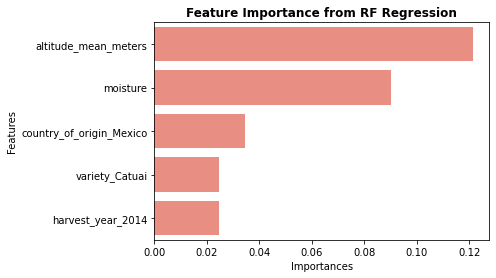

<Figure size 432x288 with 0 Axes>

In [5]:
# Inspect important features from best RF model

X_transformed = preprocessor.fit_transform(X_train)

column_names = (
    numeric_features +
    preprocessor.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)

# Top 10 features
importances = random_search.best_estimator_['randomforestregressor'].feature_importances_
feat_df = pd.DataFrame({'features': column_names, 'importances': importances})
feat_df = feat_df.sort_values('importances', ascending=False)[:5]

# --> SECOND OUTPUT: Barplot of feature importances
fig_feature_importance_RFR = sns.barplot(x="importances", y="features", data=feat_df, color="salmon").set_title('Feature Importance from RF Regression', weight='bold')
plt.xlabel("Importances")
plt.ylabel("Features")
plt.show();
plt.savefig("../results/fig_feature_importance_rfr.png")

In [6]:
# Performance on test set

random_search.score(X_test, y_test)

0.03465964279797784

### Classification

In [7]:
# train_df = pd.read_csv("../data/processed/train_df.csv")
# test_df = pd.read_csv("../data/processed/test_df.csv")

train_df['total_cup_grade'] = train_df['total_cup_points'].apply(lambda x: 'Good' if x>82 else 'Poor')
test_df['total_cup_grade'] = test_df['total_cup_points'].apply(lambda x: 'Good' if x>82 else 'Poor')


X_train_new = train_df.drop(columns=["total_cup_points", "total_cup_grade"])
X_test_new = test_df.drop(columns=["total_cup_points", "total_cup_grade"])

y_train_new = train_df["total_cup_grade"]
y_test_new = test_df["total_cup_grade"]

In [8]:
pipe = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))

results_dict['RForest_Classifier'] = pd.DataFrame(mean_std_cross_val_scores(pipe, X_train_new, y_train_new, cv=10, 
                                       return_train_score=True, scoring='roc_auc'))
results_dict

,Ridge,RForest_Regressor,RForest_Classifier
fit_time,0.010 (+/- 0.003),0.359 (+/- 0.010),0.165 (+/- 0.022)
score_time,0.005 (+/- 0.001),0.012 (+/- 0.000),0.015 (+/- 0.002)
test_score,-0.065 (+/- 0.594),0.169 (+/- 0.128),0.728 (+/- 0.058)
train_score,0.430 (+/- 0.019),0.887 (+/- 0.008),0.999 (+/- 0.000)


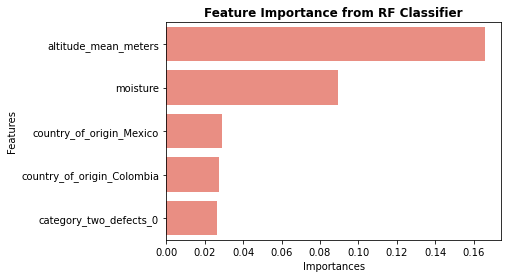

<Figure size 432x288 with 0 Axes>

In [9]:
# Inspect important features from best RF model

pipe.fit(X_train_new, y_train_new)
pipe['randomforestclassifier'].feature_importances_

column_names = (
    numeric_features +
    preprocessor.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)

# Top 5 features
importances = pipe['randomforestclassifier'].feature_importances_
feat_df = pd.DataFrame({'features': column_names, 'importances': importances})
feat_df = feat_df.sort_values('importances', ascending=False)[:5]

# --> SECOND OUTPUT: Barplot of feature importances
fig_feature_importance = sns.barplot(x="importances", y="features", data=feat_df, color="salmon").set_title('Feature Importance from RF Classifier', weight='bold')
plt.xlabel("Importances")
plt.ylabel("Features")
plt.show(fig_feature_importance);
plt.savefig("../results/feature_importance_rfc.png")

In [10]:
pipe.score(X_test_new, y_test_new)

0.6777777777777778

# References
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html <br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
